### Task 3

In [ ]:
# Step 1: Install required packages
!pip install -q kaggle kagglehub tensorflow tensorflow_probability

In [ ]:
# Step 2: Get the Dataset from Google Drive
import zipfile
import os

# Path to your zip file on Google Drive
zip_path = "/content/drive/MyDrive/divya_genai/archive.zip"

# Unzip to Colab's working directory
extract_path = "/content/celeba_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
!ls "{extract_path}"

img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


In [ ]:
# Step 3: Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

In [ ]:
# Step 4: Configure parameters
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 32
LATENT_DIM = 256
EPOCHS = 5

In [ ]:
# Load dataset from extracted path
image_dir = os.path.join(extract_path, "img_align_celeba", "img_align_celeba")
train_images = glob.glob(f"{image_dir}/*.jpg")
print(f"Found {len(train_images)} training images")

# Step 5: Verify file existence
!ls "{image_dir}" | head -n 5

Found 202599 training images
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg


In [ ]:
# Step 6: Create dataset pipeline
def load_and_preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.map(load_and_preprocess)
train_dataset = train_dataset.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Step 7: Build VAE model
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(16 * 16 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(CHANNELS, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
# Inside the encoder, just before the Sampling layer
print("Shape after conv layers:", x.shape)

# Inside the decoder, at each upsampling stage
print("Shape after dense reshape:", x.shape)
print("Shape after each Conv2DTranspose:", x.shape)


Shape after conv layers: (None, 128, 128, 64)
Shape after dense reshape: (None, 128, 128, 64)
Shape after each Conv2DTranspose: (None, 128, 128, 64)


In [ ]:
# VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= IMAGE_SIZE * IMAGE_SIZE

            # KL Divergence
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002))

# Step 8: Train the model
history = vae.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
    ]
)

Epoch 1/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 658s 101ms/step - kl_loss: 3.7532 - reconstruction_loss: 8241.2559 - total_loss: 8245.0098 - learning_rate: 2.0000e-04
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,reconstruction_loss,total_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


6332/6332 ━━━━━━━━━━━━━━━━━━━━ 673s 101ms/step - kl_loss: 4.0104 - reconstruction_loss: 7998.1821 - total_loss: 8002.1924 - learning_rate: 2.0000e-04
Epoch 3/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 681s 101ms/step - kl_loss: 3.9926 - reconstruction_loss: 7963.5713 - total_loss: 7967.5640 - learning_rate: 2.0000e-04
Epoch 4/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 682s 101ms/step - kl_loss: 3.9795 - reconstruction_loss: 7946.2075 - total_loss: 7950.1870 - learning_rate: 2.0000e-04
Epoch 5/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 645s 102ms/step - kl_loss: 3.9721 - reconstruction_loss: 7934.9653 - total_loss: 7938.9375 - learning_rate: 2.0000e-04


In [ ]:
# Step 9: Visualization functions
def plot_results(images, n_cols=5):
    n_rows = len(images) // n_cols
    plt.figure(figsize=(2.2 * n_cols, 2.2 * n_rows))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(np.clip(images[index], 0, 1))
            plt.axis("off")
    plt.tight_layout()
    plt.show()

Random generated samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


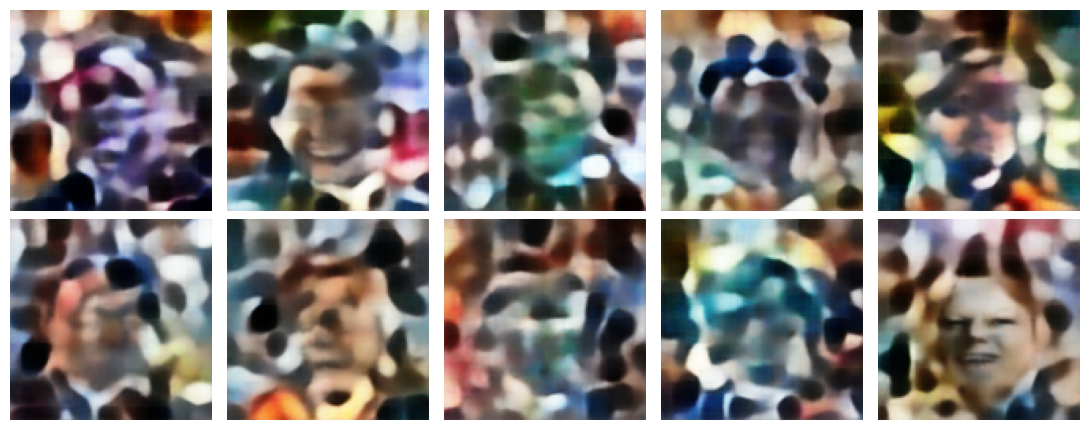

Latent space interpolation:


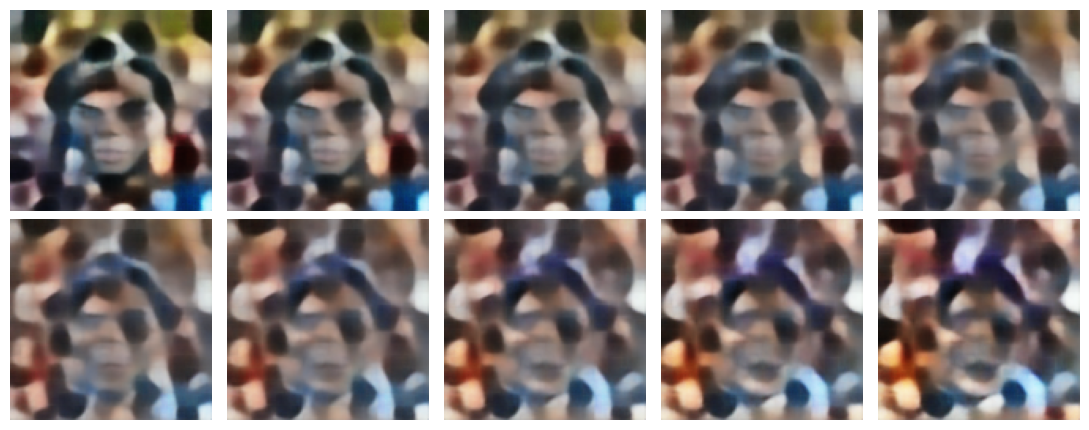

Single latent dimension variation:


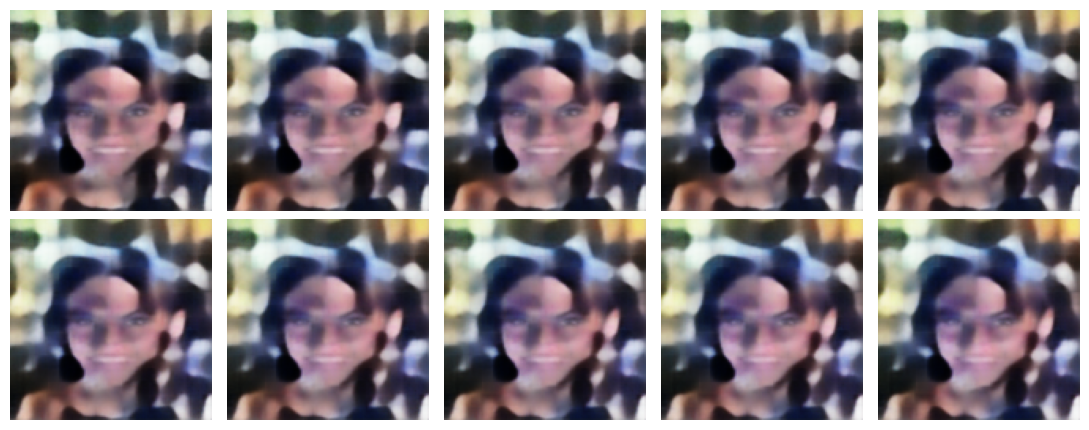

In [ ]:
# Generate random samples
print("Random generated samples:")
random_latent_vectors = tf.random.normal(shape=(10, LATENT_DIM))
generated_images = decoder.predict(random_latent_vectors)
plot_results(generated_images)

# Latent space interpolation
print("Latent space interpolation:")
z1 = tf.random.normal(shape=(1, LATENT_DIM))
z2 = tf.random.normal(shape=(1, LATENT_DIM))
interpolated = []
for t in np.linspace(0, 1, 10):
    z = z1 * (1 - t) + z2 * t
    img = decoder.predict(z, verbose=0)[0]
    interpolated.append(img)
plot_results(interpolated)

# Single dimension variation
print("Single latent dimension variation:")
fixed_z = tf.random.normal(shape=(1, LATENT_DIM))
variations = []
for delta in np.linspace(-3, 3, 10):
    z = fixed_z.numpy().copy()
    z[0, 0] = delta
    img = decoder.predict(z, verbose=0)[0]
    variations.append(img)
plot_results(variations)